             feature        VIF
0        priceScores   7.450638
1  descriptionScores  21.157999
2  contactInfoScores  34.429437
3   duplicatesScores  21.194194
4    crimeCityScores  22.212330
5    timestampScores   1.582065
All Experts Correlation:  0.16720869097141608


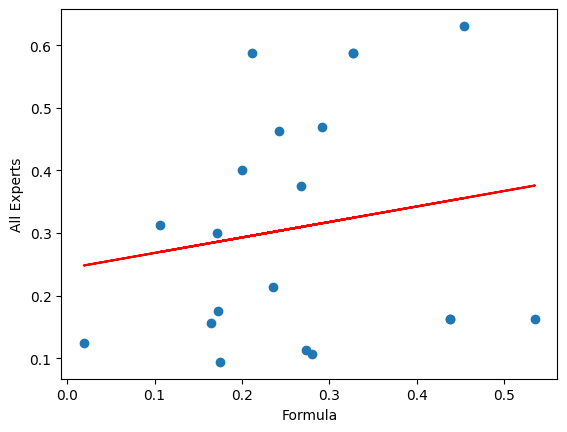

Median Expert Correlation:  0.16726568233660835


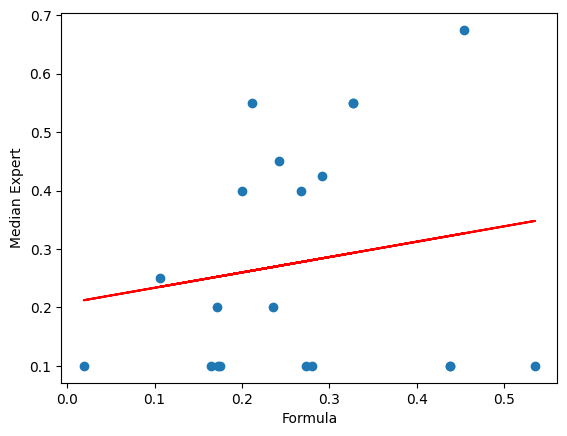

Expert Tester Correlation:  0.814812391489873


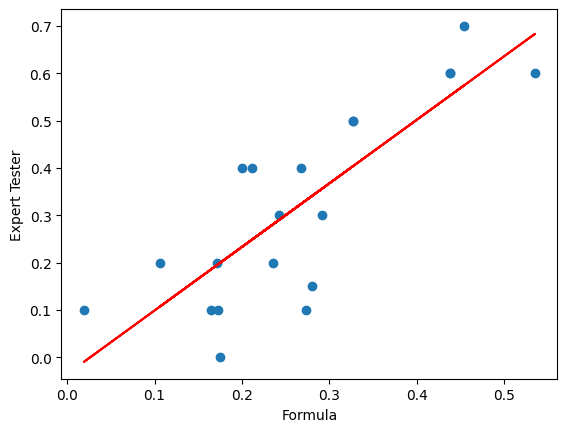

In [ ]:
# Perform linear regression testing on a given data set

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import datetime
from array import *

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt  # To visualize
import math

#data = pd.read_csv('data.csv')  # load data set

NUM_POSTS = 9               # MANUALLY CHANGE BASED ON INPUT DATA!!!
PRICE_WEIGHT = 0.25
PHOTO_WEIGHT = 0.10
DESCRIPTION_WEIGHT = 0.15
CONTACT_INFO_WEIGHT = 0.20
DUPLICATES_WEIGHT = 0.10
TIMESTAMP_WEIGHT = 0.10
CRIME_CITY_WEIGHT = 0.10

def datesToTimestamps(dates):
  timestamps = []
  for date in dates:
    date_format = datetime.datetime.strptime(date, "%m/%d/%Y")
    timestamps.append(datetime.datetime.timestamp(date_format))
  return timestamps

def calcPriceScore(marketPrice, sellerPrice):
  priceScore = PRICE_WEIGHT * (abs(marketPrice - sellerPrice) / marketPrice)
  return priceScore

def calcDescriptionScore(redFlagWords):
  descriptionScore = DESCRIPTION_WEIGHT * (1 - 1 / (redFlagWords + 1))
  return descriptionScore

def calcContactInfoScore(oddNamePhone):
  contactInfoScore = CONTACT_INFO_WEIGHT * (oddNamePhone / 2)
  return contactInfoScore

def calcDuplicatesScore(duplicates):
  duplicatesScore = DUPLICATES_WEIGHT * (1 - 1 / (duplicates + 1))
  return duplicatesScore

def calcCrimeCityScore(distance):
  crimeCityScore = CRIME_CITY_WEIGHT * ((100 - max(0,min(distance,100))) / 100)
  return crimeCityScore

def calcTimestampScore(timestamp, average):
  timestampScore = TIMESTAMP_WEIGHT * (1 / (abs(timestamp - average)/86400 + 1))
  return timestampScore

def calcRiskScore(priceScore, photoScore, descriptionScore, contactInfoScore,
                  duplicatesScore, crimeCityScore, timestampScore):
  riskScore = (priceScore + photoScore + descriptionScore + contactInfoScore
               + duplicatesScore + crimeCityScore + timestampScore)
  return riskScore


# MANUALLY FILL WITH INPUT DATA FROM EACH POST!!!
marketPrices    = [350, 350, 350, 350, 350, 350, 350, 1000, 1000]
sellerPrices    = [65, 65, 65, 300, 125, 299, 350, 1000, 1000]
redFlagWords    = [0, 0, 0, 1, 4, 0, 1, 1, 1]
oddNamesPhones  = [1, 1, 1, 1, 1, 0, 0, 2, 2]
duplicates      = [2, 2, 2, 0, 0, 296, 0, 1, 1]
crimeCityRanges = [35, 35, 35, 100, 27, 0, 0, 100, 100]
monthDayYrDates = ["8/11/2023", "7/8/2023", "6/4/2023",
                   "7/23/2023", "7/13/2023", "6/28/2023",
                   "9/12/2023", "8/16/2023", "5/18/2023"]
timestamps = datesToTimestamps(monthDayYrDates)


##### Calculate risk scores for each parameter and overall risk score #####

priceScores = []
descriptionScores = []
contactInfoScores = []
duplicatesScores = []
crimeCityScores = []
timestampScores = []
riskScores = []

for i in range(NUM_POSTS):
  priceScores.append(calcPriceScore(marketPrices[i], sellerPrices[i]))
  descriptionScores.append(calcDescriptionScore(redFlagWords[i]))
  contactInfoScores.append(calcContactInfoScore(oddNamesPhones[i]))
  duplicatesScores.append(calcDuplicatesScore(duplicates[i]))
  crimeCityScores.append(calcCrimeCityScore(crimeCityRanges[i]))

# Calculate average timestamp for each set of duplicates in data
i = 0
while i < NUM_POSTS:
  if duplicates[i] > 0:
    dups = duplicates[i]
    if (i + dups >= NUM_POSTS) or (duplicates[i+dups] != dups):
      timestampScores.append(0)
      i = i + 1
      continue
    else:
      average = np.average(timestamps[i:i+dups+1])
      for k in range(dups + 1):
        timestampScores.append(calcTimestampScore(timestamps[i+k], average))
      i = i + dups + 1
  else:
    timestampScores.append(0)
    i = i + 1

for i in range(NUM_POSTS):
  riskScores.append(calcRiskScore(priceScores[i], 0, descriptionScores[i],
                                  contactInfoScores[i], duplicatesScores[i],
                                  crimeCityScores[i], timestampScores[i]))


##### Calculate VIFs to measure collinearity of parameters #####

paramScores = {
    "priceScores" : priceScores,
    "descriptionScores" : descriptionScores,
    "contactInfoScores" : contactInfoScores,
    "duplicatesScores" : duplicatesScores,
    "crimeCityScores" : crimeCityScores,
    "timestampScores" : timestampScores
}

paramScores = pd.DataFrame(paramScores)
print(paramScores)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = paramScores.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(paramScores.values, i)
                          for i in range(len(paramScores.columns))]

print(vif_data)


##### Find correlation b/w formula and expert scores #####

# Manually enter scores gathered from expert feedback
testScores = {
    "formula": [0.438, 0.535, 0.438, 0.211, 0.454, 0.236, 0.175, 0.327, 0.327, 0.273, 0.292, 0.171, 0.267, 0.242, 0.019, 0.173, 0.165, 0.106, 0.280, 0.200],
    "experts": [0.163, 0.163, 0.163, 0.588, 0.631, 0.213, 0.094, 0.588, 0.588, 0.113, 0.469, 0.300, 0.375, 0.463, 0.125, 0.175, 0.157, 0.313, 0.107, 0.400],
    "median": [0.1, 0.1, 0.1, 0.55, 0.675, 0.2, 0.1, 0.55, 0.55, 0.1, 0.425, 0.2, 0.4, 0.45, 0.1, 0.1, 0.1, 0.25, 0.1, 0.4],
    "principal_investigator": [0, 0, 0, 1, 0.8, 0.2, 0, 1, 1, 0, 1, 0.9, 0, 0.9, 0, 0.6, 0, 0.7, 0, 0.6],
    "research_assistant": [0.1, 0.1, 0.1, 0.4, 0.65, 0.1, 0.05, 0.4, 0.4, 0.1, 0.45, 0.1, 0.5, 0.6, 0.1, 0.1, 0.1, 0.2, 0.1, 0.55],
    "expert_tester": [0.6, 0.6, 0.6, 0.4, 0.7, 0.2, 0, 0.5, 0.5, 0.1, 0.3, 0.2, 0.4, 0.3, 0.1, 0.1, 0.1, 0.2, 0.15, 0.4]
}

testScores              = pd.DataFrame(testScores)
formula                 = np.array(testScores['formula'].values.reshape(-1, 1))
experts                 = np.array(testScores['experts'].values.reshape(-1, 1))
median                  = np.array(testScores['median'].values.reshape(-1, 1))
principal_investigator  = np.array(testScores['principal_investigator'].values.reshape(-1, 1))
research_assistant      = np.array(testScores['research_assistant'].values.reshape(-1, 1))
expert_tester           = np.array(testScores['expert_tester'].values.reshape(-1, 1))

# Linear regression with all experts averaged together
model = LinearRegression()
model.fit(formula, experts) # Fit the model to the data
print("All Experts Correlation: ", math.sqrt(model.score(formula, experts)))
Y_pred = model.predict(formula)  # make predictions
plt.xlabel("Formula")
plt.ylabel("All Experts")
plt.scatter(formula, experts)
plt.plot(formula, Y_pred, color='red')
plt.show()

# Linear regression with median expert scores
model = LinearRegression()
model.fit(formula, median)  # Fit the model to the data
print("Median Expert Correlation: ", math.sqrt(model.score(formula, median)))
Y_pred = model.predict(formula)  # make predictions
plt.xlabel("Formula")
plt.ylabel("Median Expert")
plt.scatter(formula, median)
plt.plot(formula, Y_pred, color='red')
plt.show()

# Lienar regression with most accurate, expert tester
model = LinearRegression()
model.fit(formula, expert_tester) # Fit the model to the data
print("Expert Tester Correlation: ", math.sqrt(model.score(formula, expert_tester)))
Y_pred = model.predict(formula)  # make predictions
plt.xlabel("Formula")
plt.ylabel("Expert Tester")
plt.scatter(formula,  expert_tester)
plt.plot(formula, Y_pred, color='red')
plt.show()
